In [1]:
import os

import torch
import torchvision
from torch import nn
from torchsummary import summary

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from PIL import Image
import tqdm.notebook as tqdm

In [2]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
NUM_TRAIN = 45000 # set aside the first 45000 images for training and the remaining 5000 for validation
batch_size = 64

def get_cifar_transform(cifar_tensor):
  data = cifar_tensor.data
  mean = np.mean(data / 255, axis=(0,1,2))
  std = np.std(data / 255, axis=(0,1,2))

  transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=mean, std=std)
  ])
  return transform

unnormalized_trainset = torchvision.datasets.CIFAR10(root='data', train=True,download=True, transform=torchvision.transforms.ToTensor())


transform = get_cifar_transform(unnormalized_trainset)
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)


                          
train_loader = torch.utils.data.DataLoader(
  dataset=training_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(range(NUM_TRAIN))
)

val_loader = torch.utils.data.DataLoader(
  dataset=training_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(range(NUM_TRAIN, len(training_data)))
)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


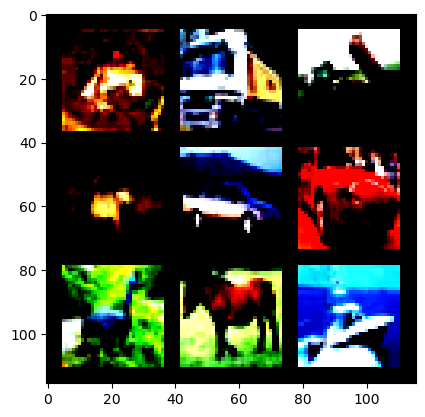

In [3]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [4]:
# ---- Plotting ----
plt.figure(figsize=(15, 10))

def plot_loss(log, save=False):
    train_loss = log['train']['loss']
    val_loss = log['val']['loss']
    
    plt.plot(train_loss, label="training loss")
    plt.plot(val_loss, label="validation loss")
    
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    plt.title("CIFAR-10 Training and Validation Loss vs Epoch")
    if save:
        plt.savefig("Loss")
        plt.close()

def plot_accuracy(log, save=False):
    train_acc = log['train']['acc']
    val_acc = log['val']['acc']
    
    plt.plot(train_acc, label="training accuracy")
    plt.plot(val_acc, label="validation accuracy")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("CIFAR-10 Training and Validation Accuracy vs Epoch")
    if save:
        plt.savefig("Accuracy")
        plt.close()

<Figure size 1500x1000 with 0 Axes>

In [5]:
# Utils

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    else:
        "cpu"
    if verbose: print(f"Using device {device}")
    return device


def make_training_log():
    training_log = {
        'train': {
            'loss': [],
            'acc': []
        },
        'val': {
            'loss': [],
            'acc': []
        }
    }
    return training_log

In [6]:
def record_acc_and_loss(model, loss_fn, data_loader, log, data_set):
    ncorrect = 0
    loss_total = 0
    nsamples = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm.tqdm(data_loader, unit="batch"):
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            
            loss = loss_fn(scores, y)
            loss_total += loss
            
            predictions = torch.argmax(scores, dim=1)
            ncorrect = (predictions == y).sum()
            nsamples += predictions.size(0)
            
        avg_loss = loss_total.cpu() / nsamples   # Move data to CPU for plotting
        acc = ncorrect / nsamples
        
        log[data_set]['loss'].append(avg_loss)
        log[data_set]['acc'].append(acc)
        
        report = "%s:\n\tAvg Loss = %.5f\n\tAccuracy = %.5f" % (data_set.capitalize(), avg_loss, acc)
        return report
    

def train(model, optimizer, loss_fn, epochs=1):
    """
    Train the given model and report accuracy and loss during training.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: dictionary of train and validation loss and accuracy for each epoch.
    """
    # Move model to device
    model = model.to(device=device)
    
    # Init LR schedulers
    scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler_plat = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    training_log = make_training_log()
    for e in range(1, epochs + 1):
        print(f"Epoch {e}")
        for x, y in tqdm.tqdm(train_loader, unit="batch"):
            model.train()
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.long)
            
            # Forward pass: compute class scores
            scores = model(x)
            loss = loss_fn(scores, y)
            
            # Remove the gradients from the previous step
            optimizer.zero_grad() 
            
            # Backward pass: update weights
            loss.backward()
            optimizer.step()
        
        # Update log of train and validation accuracy and loss. Print progress.
        train_report = record_acc_and_loss(model, loss_fn, train_loader, training_log, 'train')
        valid_report = record_acc_and_loss(model, loss_fn, val_loader, training_log, 'val')
        print(train_report, '\n', valid_report)
        
        # Save model parameters with best validation accuracy
        val_accs = training_log['val']['acc']
        if val_accs[-1] == max(val_accs):
            torch.save(model.state_dict(), "best.pth")
         
        # Update optimizer
        scheduler_exp.step()
        scheduler_plat.step(training_log['val']['loss'][-1])
    return training_log

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.LazyLinear):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
        

def get_model_summary(dummy_model, input_shape=(3, 32, 32)):
    """Get the current model configuration."""
    dummy_loader = torch.utils.data.DataLoader(
      dataset=training_data,
      batch_size=1,
      sampler=torch.utils.data.SubsetRandomSampler(range(1))
    )
    dummy_model.to(device=get_device())
    dummy_model.eval()
    with torch.no_grad():
        x, y = next(iter(dummy_loader))
        x = x.to(device=device, dtype=torch.float)
        y = y.to(device=device, dtype=torch.long)
        scores = dummy_model(x)
    try:
        s = summary(dummy_model)
        with open('model_summary.txt', 'w') as f:
            f.write(str(s))
    except ValueError as verr:
        print(verr)
    finally:
        dummy_model.cpu()
        del dummy_loader

device = get_device()

In [7]:
# ---- (CIFAR_10) Model for testing purposes ----

class CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 128, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.025),

            nn.Conv2d(128, 128, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.025),

            nn.Conv2d(128, 128, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.025),
            
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.025),

            nn.Conv2d(256, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.025),

            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 400, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(400),
            nn.Dropout2d(p=0.025),

            nn.Conv2d(400, 400, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(400),
            nn.Dropout2d(p=0.025),
            
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()

        self.linear_stack = nn.Sequential(
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout1d(p=0.2),

            nn.LazyLinear(512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            nn.LazyLinear(10),
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        out = torch.flatten(out, start_dim=1)
        out = self.linear_stack(out)
        return out

get_model_summary(CIFAR())

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,584
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  256
|    └─Dropout2d: 2-4                    --
|    └─Conv2d: 2-5                       147,584
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  256
|    └─Dropout2d: 2-8                    --
|    └─Conv2d: 2-9                       147,584
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 256
|    └─Dropout2d: 2-12                   --
|    └─MaxPool2d: 2-13                   --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-14                      295,168
|    └─ReLU: 2-15                        --
|    └─BatchNorm2d: 2-16                 512
|    └─Dropout2d: 2-17                   --
|    └─Conv2d: 2-18                      590,080
|    └─ReLU: 2-19                        --


Epoch 1


  0%|          | 0/704 [00:00<?, ?batch/s]

  0%|          | 0/704 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Train:
	Avg Loss = 0.01907
	Accuracy = 0.00011 
 Val:
	Avg Loss = 0.01914
	Accuracy = 0.00100
Epoch 2


  0%|          | 0/704 [00:00<?, ?batch/s]

  0%|          | 0/704 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Train:
	Avg Loss = 0.01385
	Accuracy = 0.00011 
 Val:
	Avg Loss = 0.01414
	Accuracy = 0.00120
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,584
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  256
|    └─Dropout2d: 2-4                    --
|    └─Conv2d: 2-5                       147,584
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  256
|    └─Dropout2d: 2-8                    --
|    └─Conv2d: 2-9                       147,584
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 256
|    └─Dropout2d: 2-12                   --
|    └─MaxPool2d: 2-13                   --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-14                      295,168
|    └─ReLU: 2-15                        --
|    └─BatchNorm2d: 2-16                 512
|    └─Dropout2d: 2-17                   --

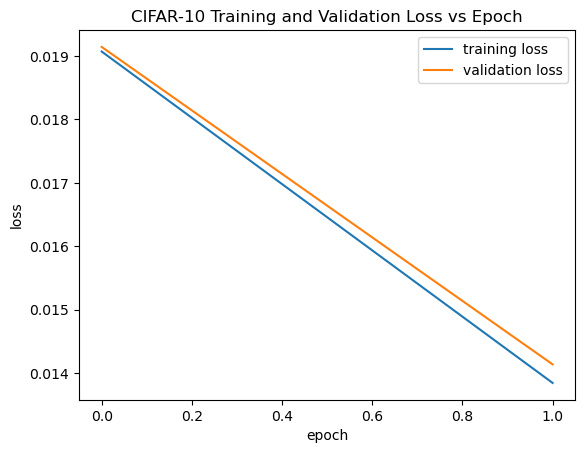

In [8]:
# Training config
learning_rate = 0.005
momentum=0.9

model = CIFAR()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler_plat = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

loss_fn = nn.CrossEntropyLoss()


training_log = train(model, optimizer, loss_fn, epochs=2)


get_model_summary(model)
plot_loss(training_log)
plt.show(training_log)
plt.close()

In [ ]:
class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("TEST_DATA.npy"), "You must upload the test data to the file system."
        self.data = [np.load("TEST_DATA.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform, # NOTE: Make sure transform is the same as the one used in the training dataset.
)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=False)
# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = []
with torch.no_grad():
      model.eval() # Put model in eval mode
      for x in tqdm.tqdm(test_dataloader, unit="batch"):
          x = x.float().to(device)
          pred = model(x)
          predictions = torch.cat((predictions, torch.argmax(pred, dim=1)))
print(predictions)


In [ ]:
# This code below will generate the predictions.csv file.
import pandas as pd

predictions = predictions.cpu()

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('predictions.csv', index_label='Id')
